In [13]:
import numpy as np
from scipy.optimize import dual_annealing
import pulp
import pandas as pd
import os
import random
from wmape import WMAPE
from order_generator import OrderGenerator
from order_merger import OrderMerger
import math
import matplotlib.pyplot as plt
from order_allocator import OrderAllocator

In [2]:
random.seed(42)

In [27]:
# Objective Function
def objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day):
    # Apply the current allocation to the orders dataframe
    orders_df['site'] = current_allocation

    # Aggregate the orders for the initial and target lead days
    aggregated_initial_df = OrderMerger.aggregate_items(orders_df, initial_day)
    aggregated_target_df = OrderMerger.aggregate_items(target_orders_df, target_day)

    # Merge the aggregated dataframes
    merged_df = OrderMerger.merge_allocation(aggregated_initial_df, aggregated_target_df, initial_day, target_day)

    # Calculate WMAPE
    _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{initial_day}', f'lead_{target_day}')
    return wmape_site

In [195]:
def initial_population(orders_df, allocated_order_eligibility, allocated_factory_caps, n_population=10):
    
    population = []
    for _ in range(n_population):
        allocated_orders = OrderAllocator.allocate_orders(orders_df.copy(), allocated_order_eligibility.copy(), allocated_factory_caps.copy())
        population.append(allocated_orders['site'].tolist())
    return population


def fitness_prob(population, orders_df, target_orders_df, initial_day, target_day):
   
    total_dist_all_individuals = [objective_function(ind, orders_df, target_orders_df, initial_day, target_day) for ind in population]
    max_population_cost = max(total_dist_all_individuals)
    population_fitness = max_population_cost - np.array(total_dist_all_individuals)
    population_fitness_sum = sum(population_fitness)
    population_fitness_probs = population_fitness / population_fitness_sum
    return population_fitness_probs


def roulette_wheel(population, fitness_probs):
    
    population_fitness_probs_cumsum = fitness_probs.cumsum()
    selected_individual_index = np.where(population_fitness_probs_cumsum >= np.random.uniform(0, 1))[0][0]
    return population[selected_individual_index]


def crossover(parent_1, parent_2, orders_df):

    parent_1 = np.array(parent_1)
    parent_2 = np.array(parent_2)
    offspring_1 = np.array(parent_1.copy())
    offspring_2 = np.array(parent_2.copy())
    order_ids = orders_df['order_id'].unique()
    
    # Choose a crossover point
    crossover_point = random.randint(1, len(order_ids) - 1)
    
    for order_id in order_ids[:crossover_point]:
        indices = list(orders_df[orders_df['order_id'] == order_id].index)
        offspring_1[indices] = parent_2[indices]
        offspring_2[indices] = parent_1[indices]
        
    return list(offspring_1), list(offspring_2)

def mutation(offspring, orders_df):
    
    offspring = np.array(offspring)
    order_ids = orders_df['order_id'].unique()
    order_id_to_mutate = random.choice(order_ids)
    indices = list(orders_df[orders_df['order_id'] == order_id_to_mutate].index)
    
    # Choose another site randomly
    new_site = random.choice(orders_df['site'].unique())
    
    # Mutate the entire order
    offspring[indices] = new_site
    
    return list(offspring)

In [196]:
def run_ga(orders_df, target_orders_df, allocated_order_eligibility, allocated_factory_caps, initial_day, target_day, n_population, n_generations, crossover_per, mutation_per):
    population = initial_population(orders_df, allocated_order_eligibility, allocated_factory_caps, n_population)
    
    for i in range(n_generations):
        fitness_probs = fitness_prob(population, orders_df, target_orders_df, initial_day, target_day)
        parents_list = [roulette_wheel(population, fitness_probs) for _ in range(int(crossover_per * n_population))]
        
        offspring_list = []
        for i in range(0, len(parents_list), 2):
            parent_1 = parents_list[i]
            parent_2 = parents_list[i + 1] if i + 1 < len(parents_list) else parents_list[0]
            offspring_1, offspring_2 = crossover(parent_1, parent_2, orders_df)
            if random.random() < mutation_per:
                offspring_1 = mutation(offspring_1, orders_df)
            if random.random() < mutation_per:
                offspring_2 = mutation(offspring_2, orders_df)
            offspring_list.extend([offspring_1, offspring_2])
        
        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_prob(mixed_offspring, orders_df, target_orders_df, initial_day, target_day)
        sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
        best_fitness_indices = sorted_fitness_indices[:n_population]
        population = [mixed_offspring[i] for i in best_fitness_indices]
        
    best_individual = population[0]
    best_energy = objective_function(best_individual, orders_df, target_orders_df, initial_day, target_day)
    return best_individual, best_energy


def save_allocations(orders_df, best_allocation, lead_day, dir_name):
    orders_df['site'] = best_allocation
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    orders_df.to_csv(f"{dir_name}/ga_allocation_lead_day_{lead_day}.csv", index=False)

In [200]:
order_dir = 'order_dataframes'
eligibility_dir = 'order_eligibility_dataframes'
allocation_dir = 'allocations'
ga_allocation_dir = 'ga_allocations'


alpha = 0.99
n_population = 20
n_generations = 5
crossover_per = 0.8
mutation_per = 0.1

factory_caps = OrderGenerator.load_factory_caps('factory_caps.json')
lead_days = list(range(18, -1, -1)) 

previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')
previous_df.to_csv(f'{ga_allocation_dir}/ga_allocation_lead_day_{lead_days[0]}.csv', index=False)

for i in range(1, len(lead_days)):
    current_day = lead_days[i]
    previous_day = lead_days[i - 1]

    current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')
    orders_eligibility_df = pd.read_csv(f'{eligibility_dir}/orders_eligibility_lead_day_{current_day}.csv')

    best_allocation, best_energy = run_ga(
        current_df.copy(), previous_df.copy(), orders_eligibility_df.copy(), factory_caps.copy(), 
        current_day, previous_day, n_population, n_generations, crossover_per, mutation_per
    )
    save_allocations(current_df, best_allocation, current_day, ga_allocation_dir)
    previous_df = pd.read_csv(f"{ga_allocation_dir}/ga_allocation_lead_day_{current_day}.csv")

[0.35786364755107064, 0.35786364755107064, 0.37336943145459023, 0.35540241201082945, 0.3645089835097219, 0.3598326359832636, 0.35687915333497416, 0.3561407826729018, 0.35712527688899826, 0.3551562884568053, 0.35663302978095, 0.3551562884568053, 0.36032488309131183, 0.35810977110509473]
[0.3551562884568053, 0.3561407826729018, 0.35663302978095, 0.35712527688899826, 0.3551562884568053, 0.35540241201082945, 0.3551562884568053, 0.3558946591188777, 0.35466404134875706, 0.3536795471326606, 0.35934038887521536, 0.36007875953728774, 0.3522028058085159, 0.3563869062269259, 0.354417917794733]
[0.3522028058085159, 0.3536795471326606, 0.354417917794733, 0.35466404134875706, 0.3551562884568053, 0.3551562884568053, 0.3551562884568053, 0.35540241201082945, 0.3558946591188777, 0.3561407826729018, 0.3563869062269259, 0.35663302978095, 0.35712527688899826, 0.35934038887521536]
[0.354417917794733, 0.3551562884568053, 0.354417917794733, 0.3551562884568053, 0.35540241201082945, 0.3522028058085159, 0.353679

In [202]:
def calculate_and_plot_wmape(pairs):
    wmape_site_values = []
    wmape_global_values = []
    wmape_site_sa_values = []
    wmape_global_sa_values = []

    ga_allocation_dir = 'ga_allocations'  # Path to the directory containing the simulated annealing allocation files
    ga_merged_allocation_dir = 'ga_merged_consec'  # Path to the directory to save the merged allocation files

    for current_day, previous_day in pairs:


        merged_df = pd.read_csv(f'merged_consec/merged_allocation_lead_day_{current_day}_to_{previous_day}.csv')
        _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{current_day}', f'lead_{previous_day}')
        _, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{current_day}', f'lead_{previous_day}')

        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)

        # With simulated annealing
        current_df_ga = pd.read_csv(f'{ga_allocation_dir}/ga_allocation_lead_day_{current_day}.csv')
        previous_df_ga = pd.read_csv(f'{ga_allocation_dir}/ga_allocation_lead_day_{previous_day}.csv')

        aggregated_current_day_ga = OrderMerger.aggregate_items(current_df_ga, current_day)
        aggregated_previous_day_ga = OrderMerger.aggregate_items(previous_df_ga, previous_day)

        merged_df_sa_2opt = OrderMerger.merge_allocation(aggregated_current_day_ga, aggregated_previous_day_ga, current_day, previous_day)

        _, wmape_site_sa = WMAPE.calculate_wmape_site(merged_df_sa_2opt, f'lead_{current_day}', f'lead_{previous_day}')
        _, wmape_global_sa = WMAPE.calculate_wmape_global(merged_df_sa_2opt, f'lead_{current_day}', f'lead_{previous_day}')

        wmape_site_sa_values.append(wmape_site_sa)
        wmape_global_sa_values.append(wmape_global_sa)

        # Save the merged dataframes with simulated annealing
        merged_df_sa_2opt.to_csv(f'{ga_merged_allocation_dir}/merged_allocation_ga_lead_day_{current_day}_to_{previous_day}.csv', index=False)

    lead_days_consecutive = [previous_day for _, previous_day in pairs]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lead_days_consecutive, wmape_site_values, linestyle='-', color='b', label='WMAPE Site Without Genetic Algorithm')
    ax.plot(lead_days_consecutive, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')
    ax.plot(lead_days_consecutive, wmape_site_sa_values, linestyle='--', color='b', label='WMAPE Site With Genetic Algorithm')

    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Consecutive Lead Days')
    ax.set_xticks(lead_days_consecutive)
    ax.legend()

    ax.invert_xaxis()

    plt.show()

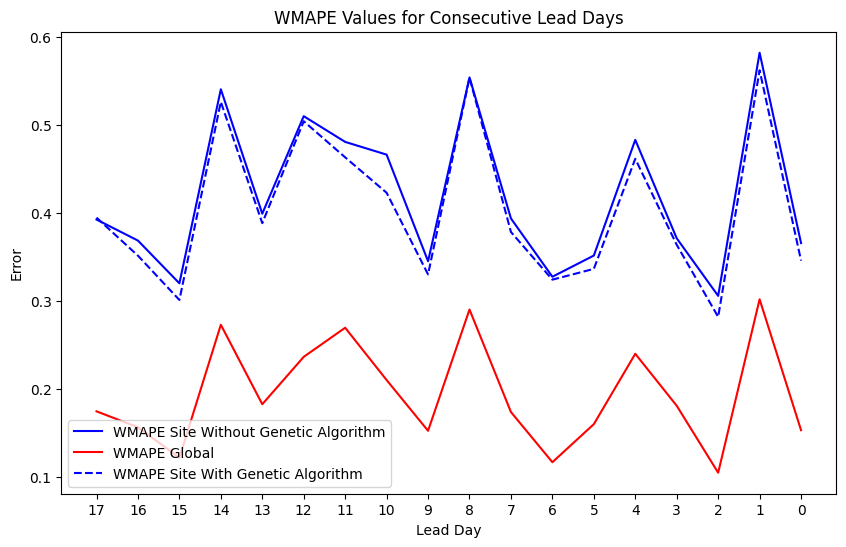

In [203]:
pairs = [(18, 17), (17, 16), (16, 15), (15, 14), (14, 13), (13, 12), (12, 11), (11, 10), (10, 9), (9, 8), (8, 7), (7, 6), (6, 5), (5, 4), (4, 3), (3, 2), (2, 1), (1, 0)]
calculate_and_plot_wmape(pairs)